### Alternative approach using SVM

In [1]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
start = time.time()
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000427007675171


In [3]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [4]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 4.50604486465


In [5]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

### Loading the features of the cells

In [6]:
cells = pd.read_csv('/home/dueo/data/Genedata/Cells.csv')

In [15]:
cells[0:10]
cells.

SyntaxError: invalid syntax (<ipython-input-15-0b454546d70a>, line 2)

### Extracting the features and imputing NaNs

In [7]:
X_features = np.asmatrix(cells.ix[cell_rows,11:])
np.shape(X_features)

(52950, 396)

In [8]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_features)
X_features = imp.transform(X_features)

### Normalization

In [9]:
Xmean = X_features.mean(axis = 0)
XStd = np.sqrt(X_features.var(axis=0))
X = (X_features-Xmean)/(XStd + 0.1)

In [10]:
np.max(X[:,1])

1.8164506533032305

In [11]:
np.min(X), np.max(X), np.mean(X)

(-9.5833446880979825, 132.67998438665234, -2.6729815147106906e-18)

In [12]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

### Splitting in training and test-set



#### Version 2
80%, 20% randomly choosen

In [13]:
# Currently a Acc. of 0.8250
split = 40000
X_train = X[0:split,:]
Y_train = Y[0:split]
X_test = X[split:,:]
Y_test = Y[split:]

In [14]:
# Currently a Acc. of 0.8976
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]
    

X_train = X[idx_train,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:]
Y_test = Y[idx_test]

Sum of permutation 1401824775


#### Permuting the training set

In [15]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:]
YY = Y_train[perm]

### 10 Fold X-Validation

We use a 10 fold crossvalidation on the training set to find the optimal parameters

### Sampling 

For the SVM we sample so that the classes have equal proportions.

In [16]:
hist = np.histogram(YY, bins=[0, 1, 2, 3,4])
NMAX = np.min(hist[0])
hist, NMAX

((array([32566,  1585,  7877,   332]), array([0, 1, 2, 3, 4])), 332)

In [17]:
idx3 = np.argwhere(YY == 3)[0:NMAX]
idx2 = np.argwhere(YY == 2)[0:NMAX]
idx1 = np.argwhere(YY == 1)[0:NMAX]
idx0 = np.argwhere(YY == 0)[0:NMAX]
idx_d = np.concatenate((idx0,idx1,idx2,idx3))[:,0] #Orderedness is problem in studip k-fold
perm_d = np.random.permutation(len(idx_d))
idx = idx_d[perm_d]

In [18]:
XX1 = XX[idx]
YY1 = YY[idx]
np.shape(XX1), np.shape(YY1),np.shape(XX),np.shape(idx)

((1328, 396), (1328,), (42360, 396), (1328,))

In [19]:
np.histogram(YY1,  bins=[0, 1, 2, 3,4])

(array([332, 332, 332, 332]), array([0, 1, 2, 3, 4]))

In [20]:
YY1[1:10]

array([3, 2, 2, 0, 2, 2, 0, 0, 0], dtype=int32)

In [21]:
def eval_10_Fold(C = 0.5):
    N = len(XX1)
    kf = KFold(N, n_folds=10)
    acc = 0.0
    rounds = 0.0
    for train, test in kf:
        model = svm.SVC(kernel='linear', C=C).fit(XX1[train,],YY1[train])
        res = model.predict(XX1[test])
        acc += sum(res == YY1[test])/float(len(test)) #Accuracy
        rounds += 1.0
        print('round ={0} C={1} acc (cumulated over the faults) ={2}'.format(rounds, C, acc / rounds))
    return acc

In [22]:
#Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1,1e2,1e3)
Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1)
res = np.zeros(len(Cs))
for i,C in enumerate(Cs):
    res[i] = eval_10_Fold(C)

round =1.0 C=0.001 acc (cumulated over the faults) =0.714285714286
round =2.0 C=0.001 acc (cumulated over the faults) =0.755639097744
round =3.0 C=0.001 acc (cumulated over the faults) =0.764411027569
round =4.0 C=0.001 acc (cumulated over the faults) =0.781954887218
round =5.0 C=0.001 acc (cumulated over the faults) =0.777443609023
round =6.0 C=0.001 acc (cumulated over the faults) =0.770676691729
round =7.0 C=0.001 acc (cumulated over the faults) =0.780880773362
round =8.0 C=0.001 acc (cumulated over the faults) =0.792293233083
round =9.0 C=0.001 acc (cumulated over the faults) =0.791802739171
round =10.0 C=0.001 acc (cumulated over the faults) =0.80125882889
round =1.0 C=0.005 acc (cumulated over the faults) =0.774436090226
round =2.0 C=0.005 acc (cumulated over the faults) =0.804511278195
round =3.0 C=0.005 acc (cumulated over the faults) =0.812030075188
round =4.0 C=0.005 acc (cumulated over the faults) =0.821428571429
round =5.0 C=0.005 acc (cumulated over the faults) =0.81954887

((0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0),
 array([ 8.01258829,  8.39633174,  8.47903851,  8.65248348,  8.51680337,
         8.39644566,  8.19326726]))

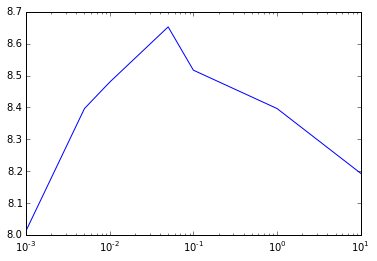

In [23]:
plt.semilogx(Cs,res)
(Cs,res)

### Evaluation on the test set

Training the model on the whole training data set

In [24]:
model = svm.SVC(kernel='linear', C=0.1).fit(XX1,YY1)

In [25]:
pred = model.predict(X_test)

In [26]:
sum(pred == Y_test)/float(len(Y_test))

0.82502360717658163

### Calucation of the confusion matrix

In [28]:
names_col = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names_col
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,6899,9,388,0
PACLITAXEL Pred,62,369,112,0
METOCLOPRAMIDE Pred,1222,16,1387,0
DIGOXIN Pred,34,9,1,82


In [33]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))
print('Normalized confusion matrix')


df = pd.DataFrame(cm_normalized)
df.columns = names_col
df.index = names
df

Normalized confusion matrix


,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,0.839601,0.022333,0.205508,0
PACLITAXEL Pred,0.007545,0.915633,0.059322,0
METOCLOPRAMIDE Pred,0.148716,0.039702,0.734640,0
DIGOXIN Pred,0.004138,0.022333,0.000530,1


In [34]:
np.mean(cm_normalized[np.diag_indices(4)])

0.87246835310088522

In [124]:
1-np.mean(cm_normalized[np.diag_indices(4)])

0.1640837792028218